In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier/ 2.))
    probs = [comb(n_classifier, k) *
            error**k * (1-error)**(n_classifier - k) for k in range(k_start, n_classifier +1)]
    return sum(probs)
ensemble_error(n_classifier=11, error= 0.25)

np.float64(0.03432750701904297)

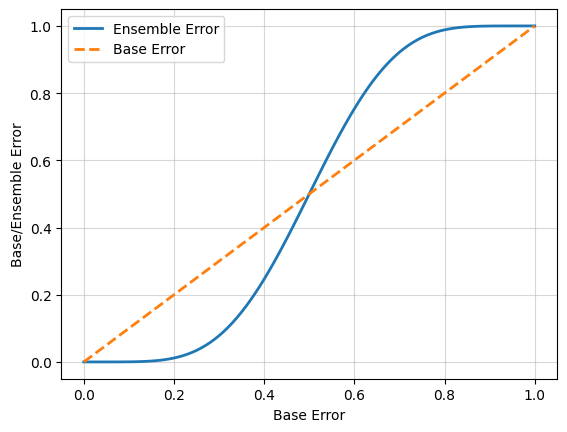

In [2]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier=11,error=error) for error in error_range]
plt.plot(error_range,ens_error, label='Ensemble Error', linewidth = 2)
plt.plot(error_range,error_range, linestyle='--', label='Base Error', linewidth = 2)
plt.xlabel("Base Error")
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='upper left')
plt.grid(alpha = 0.5)
plt.show()

In [3]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
                      weights = [0.2, 0.2, 0.6]))

np.int64(1)

In [4]:
ex = np.array([[0.9, 0.1],
              [0.8,0.2],
              [0.4,0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [5]:
np.argmax(p)

np.int64(0)

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기

    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)

    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬

        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터

        반환값
        -------
        self : 객체

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬

        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬

        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [7]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y,
                        test_size=0.5,
                        random_state=1,
                        stratify=y)

In [8]:
X_train ,X_test,y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=1, stratify=y)

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [15]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: nan (+/- nan) [Majority voting]


In [11]:
import warnings
warnings.filterwarnings('ignore')

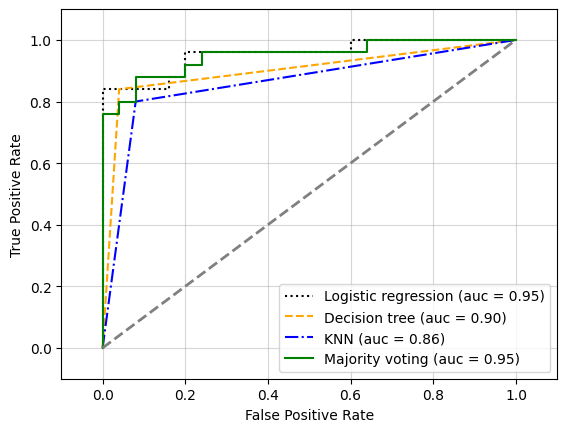

In [12]:
from sklearn.metrics import roc_curve, auc
colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label="%s (auc = %0.2f)"%(label,roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],
         linestyle = '--',
         color = 'gray',
         linewidth = 2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [13]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

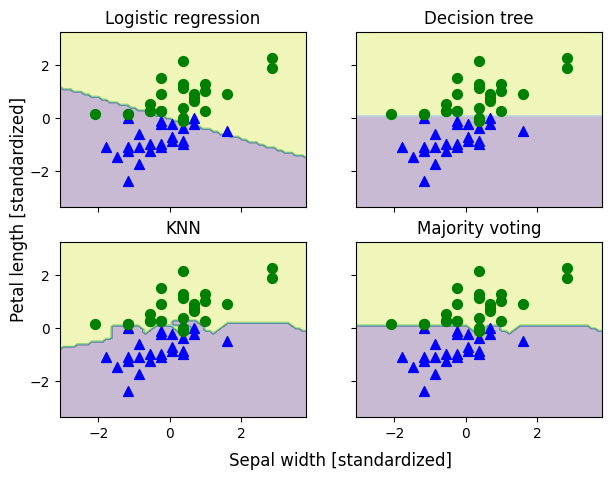

In [16]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

plt.show()


In [17]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r],
             grid.cv_results_['std_test_score'][r] / 2.0,
             grid.cv_results_['params'][r]))

nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [39]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: nan


In [18]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash','Alcalinity of ash',
                   'Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols',
                   'Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines',
                   'Proline']



In [19]:
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1, stratify=y)

In [21]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state = 1, max_depth=None)
bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)




In [22]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision Tree Train Accuracy: %.3f' % tree_train)
print('Decision Tree Test Accuracy: %.3f' % tree_test)

Decision Tree Train Accuracy: 1.000
Decision Tree Test Accuracy: 0.833


In [26]:
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' %(bag_train,bag_test))

배깅의 훈련 정확도/테스트 정확도 1.000/0.917


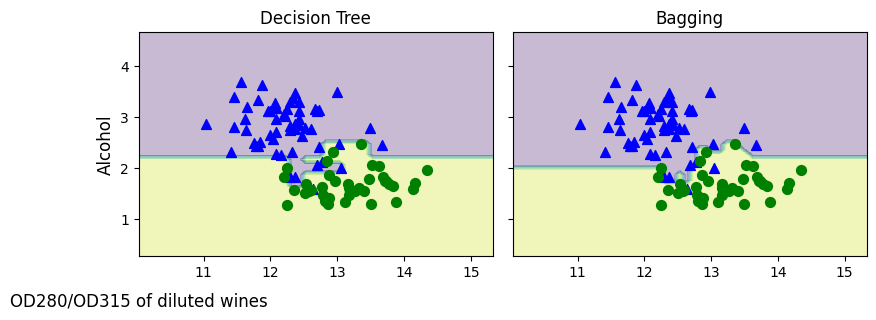

In [27]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx ,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=1,ncols=2,sharex='col',sharey='row',figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree,bag],['Decision Tree','Bagging']):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],X_train[y_train==0,1],c='blue',marker='^',s=50)
    axarr[idx].scatter(X_train[y_train==1,0],X_train[y_train==1,1],c='green',marker='o',s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol',fontsize=12)
plt.tight_layout()
plt.text(0,-0.2, s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12, transform=axarr[0].transAxes)
plt.show()

In [29]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(estimator=tree,n_estimators=500,random_state=1,learning_rate=0.1)
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' %(tree_train,tree_test))

배깅의 훈련 정확도/테스트 정확도 0.916/0.875


In [30]:
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' %(ada_train,ada_test))

배깅의 훈련 정확도/테스트 정확도 0.968/0.917


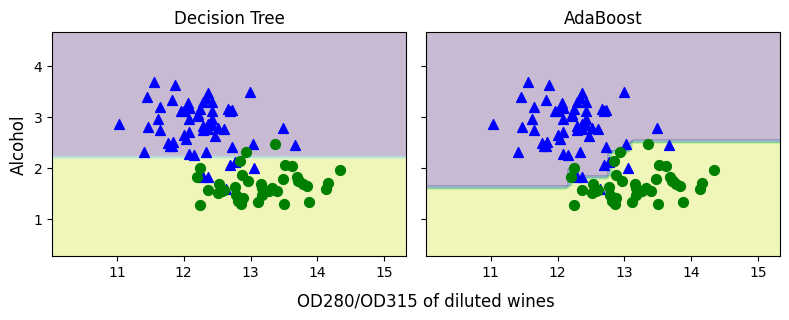

In [33]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx ,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=1,ncols=2,sharex='col',sharey='row',figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree,ada],['Decision Tree','AdaBoost']):
    clf.fit(X_train,y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],X_train[y_train==0,1],c='blue',marker='^',s=50)
    axarr[idx].scatter(X_train[y_train==1,0],X_train[y_train==1,1],c='green',marker='o',s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol',fontsize=12)
plt.tight_layout()
plt.text(0,-0.2, s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12, transform=axarr[1].transAxes)
plt.show()